Semi-supervised Community Detection using Graph Convolutional Network
=====================

Predicting community memberships of a network of entities is a common task in many real-world scenarios
working with graph data. In this tutorial, we demonstrate how to implement a Graph Convolutional Network (GCN)
[Kipf & Welling](https://arxiv.org/abs/1609.02907) using DGL to solve one such community detection problem in
a semi-supervised setting.

More specifically, you will learn:
- How to load graph data to DGLGraph?
- How to manipulate node/edge features on the graph?
- How to write a Graph Convolutional layer using message passing APIs?
- Train the model and visualize the result.

Although this tutorial uses [PyTorch](https://pytorch.org) as backend for tensor-related computations
(thus some familiarity with PyTorch is preferred), DGL is designed to be platform-agnostic and can be
seamlessly integrated into other frameworks like [MXNet](https://mxnet.apache.org/).

In [2]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

Zachery's Karate Club
---
We start by creating the well-known *"Zachary's karate club"* social network. The network captures 34 members of a karate club, documenting pairwise links between members who interacted outside the club. The club later splits into two communities led by the instructor (node 0) and club president (node 33). You could read more about the story in the [wiki page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) A visualization of the network and the community is as follows:

![karate](https://www.dropbox.com/s/uqzor4lqsmbnz8k/karate1.jpg?dl=1)

Load graph data
---
Let's see how we can load such graph to DGL. We start with importing `dgl` and other relevant packages.

In [7]:
import dgl

To create a graph in dgl, use `g = dgl.DGLGraph(graph_data)`. We support a wide range of `graph_data`. Here are some examples:

* An edge list (e.g. `[(0, 1), (1, 2), ...]`)
* A [`networkx`](https://networkx.github.io/) graph object.
* A scipy sparse matrix.

Since `networkx` already provides an API to create a karate club network, we can create a DGLGraph from it.

In [16]:
import networkx as nx

G = dgl.DGLGraph(nx.karate_club_graph())

Let's print out how many nodes and edges are there in this graph.

In [17]:
print('#Nodes', G.number_of_nodes())
print('#Edges', G.number_of_edges())

#Nodes 34
#Edges 156


DGLGraph can be converted to `networkx` very easily. For example, we can utilize `networkx` to visualize the graph:

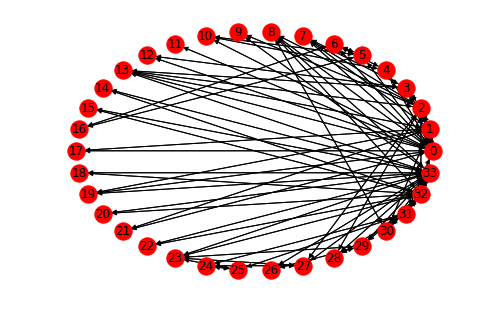

In [18]:
nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

Manipulating node/edge data
---

Nodes and edges in `DGLGraph` can have feature tensors. Features of multiple nodes/edges are batched on the first dimension. Let's start by assigning a random feature vector of length 5 to all nodes.

In [10]:
import torch

G.ndata['feat'] = torch.randn((34, 5))

Now each node has a feature vector `'feat'` that has 5 elements. Note since there are 34 nodes in this graph, the first dimension must be of size 34, so that each row corresponds to the feature vector of each node. Error will be raised if the dimension mismatches:

In [11]:
# This will raise error!!
# G.ndata['wrong_feat'] = torch.randn((35, 5))

The `G.ndata` is a dictionary-like structure, so it is compatible with any operation on dictionary.

In [15]:
# Use `dict.update` to add new features (vector of length 3)
G.ndata.update({'another_feat' : torch.randn((34, 3))})

# Print the feature dictionary
print(G.ndata)

# Delete the new feature
del G.ndata['another_feat']

{'feat': tensor([[-2.5135,  1.0564,  0.6000,  1.4855, -0.8377],
        [ 1.3733,  0.5335,  1.6506, -0.2762,  0.5691],
        [-0.4218,  2.1120,  0.1786, -0.5093,  1.1405],
        [ 1.3967,  1.0304, -0.2285, -1.8210,  0.1118],
        [ 2.0626, -0.7573, -0.4349, -0.7624,  0.7173],
        [ 0.5154, -0.3928,  0.0807,  0.8419, -0.9588],
        [-0.4652,  1.0430, -1.0900,  0.9269, -0.9910],
        [-2.6973,  0.7167, -0.0353, -0.2869,  1.3169],
        [ 0.7799, -0.5952, -0.2939, -0.8940, -1.5288],
        [-0.7288, -0.5573, -0.3668,  0.1795,  0.2297],
        [ 0.4401, -0.8169, -0.0904, -0.1148, -0.7442],
        [ 1.2990, -1.0486, -0.8549,  0.0698,  1.3280],
        [ 0.4672,  0.0753,  1.8293,  1.5628,  0.5058],
        [ 0.2125, -0.1889, -1.2809, -0.5804, -1.1658],
        [ 0.8803, -0.0378,  0.6113, -1.4786,  0.5505],
        [ 1.4251,  0.5268,  0.3419,  0.3374, -1.8574],
        [ 0.3030, -0.7921, -0.3777, -0.5012,  0.4438],
        [-0.0441, -1.2437, -0.4300,  0.2713, -1.9062],
 

Similar to `G.ndata` and `G.nodes`, we have `G.edata` and `G.edges` to access and modify edge features:

In [14]:
# The broness edge feature is just a scalar.
G.edata['broness'] = torch.ones((G.number_of_edges(),))

# Use G.edges[src, dst] syntax to read/write features of specific edges.
# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

{'broness': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.5000, 1.0000, 1.0000, 0.5000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.00

Define a GCN layer using message passing paradigm
---

Graph convolutional network (GCN) is a popular model proposed by [Kipf & Welling](https://arxiv.org/abs/1609.02907) to encode graph structure. The model consists of several layers, each perform convolution-like operation defined on graph:

$$
Y=\hat{A}XW
$$

, where $X$ is the node embedding tensor (stacked along the first dimension), $W$ is a projection matrix (the model parameter) and $\hat{A}$ is the normalized adjacency matrix:

$$
\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}
$$

The computation can be expressed in terms of **message passing paradigm**:
* Each node first computes and sends out messages via its out-going edges.
* Each node then collects in-coming messages, aggregates them and update its own embedding.

Suppose the current embedding of node $i$ is $h_i^{(t)}$. A Graph Convolution operation can be rewritten as:

$$
\text{message phase: }m_{j\rightarrow i}=h_j^{(t)}W^{(t)}
$$

$$
\text{reduce phase: }\tilde{h}_i=\sum_{j\in\mathcal{N}(i)}\frac{1}{\sqrt{d_id_j}}m_{j\rightarrow i}
$$

TODO: a figure here

In DGL, the above message passing computation can be easily implememented.

In [21]:
import dgl.function as fn

message_func = fn.copy_src('h', 'm')
reduce_func = fn.sum('m', 'h')

We then use the message function and reduce function to define a `GraphConv` module. (Example uses pytorch's nn module. One can also use `mxnet.gluon.Block`).

In [22]:
import torch.nn as nn
import torch.nn.functional as F

# Define the GraphConv module
class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.send(g.edges(), message_func)
        g.recv(g.nodes(), reduce_func)
        # get the result node features
        h = g.ndata.pop('h')
        return h

We then define a two-layer Graph Convolutional Network using the above module.

In [25]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

Now let's train this model to predict the the club membership after the split. To train the model, we adopt Kipf's semi-supervised setting:
* Only the instructor node (node 0) and the president node (node 33) are labeled.
* The initial node feature is a one-hot encoding of the node id.

In [27]:
inputs = torch.eye(34)  # featureless inputs
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for node 0 and node 33
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/home/jermaine/.local/lib/python3.7/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0 | Loss: 2.3502
Epoch 1 | Loss: 2.1772
Epoch 2 | Loss: 1.9819
Epoch 3 | Loss: 1.7815
Epoch 4 | Loss: 1.5617
Epoch 5 | Loss: 1.3067
Epoch 6 | Loss: 1.0206
Epoch 7 | Loss: 0.7295
Epoch 8 | Loss: 0.4841
Epoch 9 | Loss: 0.3574
Epoch 10 | Loss: 0.3603
Epoch 11 | Loss: 0.3651
Epoch 12 | Loss: 0.3024
Epoch 13 | Loss: 0.2089
Epoch 14 | Loss: 0.1277
Epoch 15 | Loss: 0.0768
Epoch 16 | Loss: 0.0534
Epoch 17 | Loss: 0.0465
Epoch 18 | Loss: 0.0447
Epoch 19 | Loss: 0.0424
Epoch 20 | Loss: 0.0376
Epoch 21 | Loss: 0.0309
Epoch 22 | Loss: 0.0236
Epoch 23 | Loss: 0.0169
Epoch 24 | Loss: 0.0114
Epoch 25 | Loss: 0.0074
Epoch 26 | Loss: 0.0046
Epoch 27 | Loss: 0.0029
Epoch 28 | Loss: 0.0019
Epoch 29 | Loss: 0.0013


Now let's visualize the results. Since the final node embedding is a vector of length two (for predicting two classes), we can plot it as a point on a 2D plot and visualize how the final embeddings cluster towards each other.

/home/jermaine/.local/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


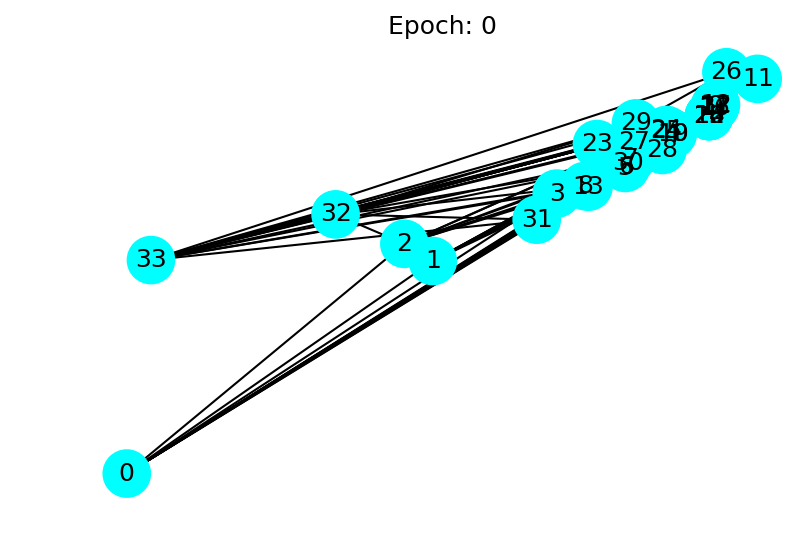

In [28]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = G.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

Advanced: writing arbitrary message and reduce function 
---

DGL provides many message and reduce functions to express different GNN variants. For instance, we support `src_mul_edge` as message function and `max` as reduce function. A full list of built-in message and reduce functions can be found [here](https://docs.dgl.ai/features/builtin.html).

However, there is always a chance to go beyond this list. In DGL, you can define arbitrary message and reduce function in python function:

In [29]:
# Same message function as `fn.copy_src`
def gcn_message_udf(edges):
    return {'m' : edges.src['h']}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(nodes):
    return {'h' : nodes.mailbox['m'].sum(dim=1)}

The above functions perform the same computation as the built-in `copy_src` and `sum`. However, using DGL's built-in functions is much faster because we can map them to efficient CPU/GPU kernels while user-defined python functions can only be invoked in python side.